# EDA for Retail Data



In [1]:
# Importing all the libraries needed in EDA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import getpass
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

In [2]:
# Set seaborn style for better visuals
sns.set(style = 'whitegrid')

In [3]:
PW = getpass.getpass("\n Enter your snowflake password: \n")


 Enter your snowflake password: 
 ········


In [4]:
# Connect to Snowflake
try:
    conn = snowflake.connector.connect(
        user='GAURAVGM14',
        password = PW,
        account = 'phytzbh-gl41994',
        warehouse = 'GAURAV',
        database = 'RETAIL_PROJECT',
        schema = 'PUBLIC'
    )
except snowflake.connector.errors.Error as e:
    print(f"Error connecting to Snowflake: {e}")
    raise

In [5]:
# Function for fetching data from Snowflake
def fetch_data(query):
    cur = conn.cursor()
    cur.execute(query)
    df = cur.fetch_pandas_all()
    cur.close()
    return df

In [6]:
queries = {
    "CAMPAIGN_DESC_RAW":"select * from CAMPAIGN_DESC_RAW;",
    "CAMPAIGN_RAW":"select * from CAMPAIGN_RAW;",
    "COUPON_RAW":"select * from COUPON_RAW;",
    "COUPON_REDEMPT_RAW":"select * from COUPON_REDEMPT_RAW;",
    "HH_DEMOGRAPHIC_RAW":"select * from HH_DEMOGRAPHIC_RAW;",
    "PRODUCT_RAW":"select * from PRODUCT_RAW;",
    "TRANSACTIONS_RAW":"select * from TRANSACTIONS_RAW;"
}

In [7]:
# Load all data into respective dataframes
data = {name:fetch_data(query) for name,query in queries.items()}

In [8]:
# Data Overview and initial EDA
for name, df in data.items():
    print(f"Shape of {name} is {df.shape}")
    print(f"Missing values in {name}:")
    print(df.isnull().sum())    

Shape of CAMPAIGN_DESC_RAW is (30, 4)
Missing values in CAMPAIGN_DESC_RAW:
DESCRIPTION    0
CAMPAIGN       0
START_DAY      0
END_DAY        0
dtype: int64
Shape of CAMPAIGN_RAW is (7208, 3)
Missing values in CAMPAIGN_RAW:
DESCRIPTION      0
HOUSEHOLD_KEY    0
CAMPAIGN         0
dtype: int64
Shape of COUPON_RAW is (124548, 3)
Missing values in COUPON_RAW:
COUPON_UPC    0
PRODUCT_ID    0
CAMPAIGN      0
dtype: int64
Shape of COUPON_REDEMPT_RAW is (2318, 4)
Missing values in COUPON_REDEMPT_RAW:
HOUSEHOLD_KEY    0
DAY              0
COUPON_UPC       0
CAMPAIGN         0
dtype: int64
Shape of HH_DEMOGRAPHIC_RAW is (2500, 8)
Missing values in HH_DEMOGRAPHIC_RAW:
AGE_DESC               0
MARITAL_STATUS_CODE    0
INCOME_DESC            0
HOMEOWNER_DESC         0
HH_COMP_DESC           0
HOUSEHOLD_SIZE_DESC    0
KID_CATEGORY_DESC      0
HOUSEHOLD_KEY          0
dtype: int64
Shape of PRODUCT_RAW is (92353, 7)
Missing values in PRODUCT_RAW:
PRODUCT_ID              0
MANUFACTURER            0
DEP

#### Data Transformation :-

In [9]:
# Campaign data transformation

start_date = pd.to_datetime('2020-01-01')

data['CAMPAIGN_DESC_RAW']['START_DATE'] = start_date + pd.to_timedelta(data['CAMPAIGN_DESC_RAW']['START_DAY'] , 'D')
data['CAMPAIGN_DESC_RAW']['END_DATE'] = start_date + pd.to_timedelta(data['CAMPAIGN_DESC_RAW']['END_DAY'] , 'D')
data['CAMPAIGN_DESC_RAW']['DURATION'] = data['CAMPAIGN_DESC_RAW']['END_DAY']-data['CAMPAIGN_DESC_RAW']['START_DAY']

In [10]:
# Coupon redemption data transformation

data['COUPON_REDEMPT_RAW']['DATE'] = start_date + pd.to_timedelta(data['COUPON_REDEMPT_RAW']['DAY'] , 'D')

In [11]:
# Transaction data transformation

data['TRANSACTIONS_RAW']['DATE'] = start_date + pd.to_timedelta(data['TRANSACTIONS_RAW']['DAY'],'D')

#### Campaign Analysis :-

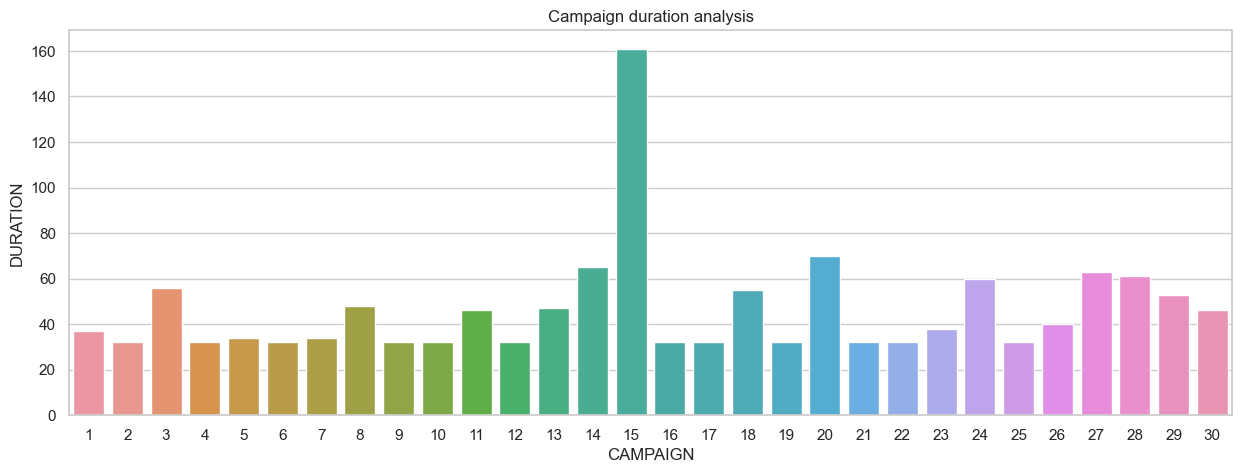

In [12]:
# Campaign Duration Analysis 

plt.figure(figsize=(15,5))
sns.barplot(x='CAMPAIGN', y='DURATION', data = data['CAMPAIGN_DESC_RAW'])
plt.title("Campaign duration analysis")
plt.show()

In [13]:
data['CAMPAIGN_DESC_RAW'].groupby('DESCRIPTION').aggregate(Total_campaigns = ('CAMPAIGN','nunique'),Avg_Duration = ('DURATION','mean'))

,Total_campaigns,Avg_Duration
DESCRIPTION,,
TypeA,5,47.200000
TypeB,19,37.631579
TypeC,6,74.500000


In [14]:
# Household participation analysis

unique_househols_campaign = data['CAMPAIGN_RAW']['HOUSEHOLD_KEY'].nunique()

total_unique_households = data['HH_DEMOGRAPHIC_RAW']['HOUSEHOLD_KEY'].nunique()

non_participating_households = total_unique_households - unique_househols_campaign

print(f"Households Participating in Campaigns are {unique_househols_campaign}")
print(f"Households not participating in campaigns are {non_participating_households}")

Households Participating in Campaigns are 1584
Households not participating in campaigns are 916


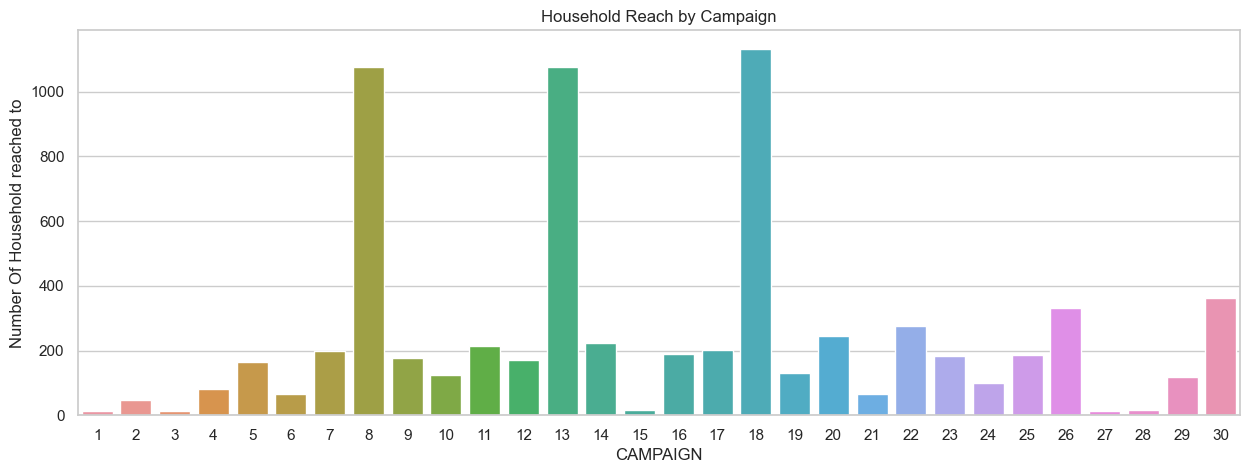

In [15]:
# Campaign wise household participation

campaign_reach = data['CAMPAIGN_RAW'].groupby('CAMPAIGN').aggregate(total_households_reached = ('HOUSEHOLD_KEY','nunique'))
campaign_reach = campaign_reach.merge(data['CAMPAIGN_DESC_RAW'], how='left', on='CAMPAIGN')

plt.figure(figsize=(15,5))
sns.barplot(data= campaign_reach, x='CAMPAIGN',y='total_households_reached')
plt.ylabel("Number Of Household reached to")
plt.title("Household Reach by Campaign")
plt.show()

#### Coupon Analysis :-

In [17]:

coupons_given = data['COUPON_RAW'].groupby('CAMPAIGN').aggregate(
    TOTAL_PRODUCTS = ('PRODUCT_ID','nunique'),
    COUPON_GIVEN = ('COUPON_UPC','nunique')
)
coupons_given = coupons_given.merge(data['CAMPAIGN_DESC_RAW'],how='left',on='CAMPAIGN')
coupons_given.loc[:,['CAMPAIGN','TOTAL_PRODUCTS','COUPON_GIVEN','START_DATE','END_DATE']]

,CAMPAIGN,TOTAL_PRODUCTS,COUPON_GIVEN,START_DATE,END_DATE
0,1,383,11,2020-12-12,2021-01-18
1,2,301,16,2020-12-17,2021-01-18
2,3,506,34,2020-12-22,2021-02-16
3,4,200,12,2021-01-07,2021-02-08
4,5,443,11,2021-01-12,2021-02-15
5,6,18,1,2021-01-28,2021-03-01
6,7,259,8,2021-02-02,2021-03-08
7,8,17178,209,2021-02-16,2021-04-05
8,9,825,18,2021-03-11,2021-04-12
9,10,393,14,2021-04-08,2021-05-10


In [18]:
# Product-level coupon analysis

coupon_product = data['COUPON_RAW'].merge(data['PRODUCT_RAW'],how='left',on='PRODUCT_ID')
print(coupon_product['COMMODITY_DESC'].value_counts().sort_values(ascending=False).head(20))

COMMODITY_DESC
HAIR CARE PRODUCTS           6261
MAKEUP AND TREATMENT         5585
FRZN MEAT/MEAT DINNERS       4893
FROZEN PIZZA                 3658
BEEF                         3314
ICE CREAM/MILK/SHERBTS       3257
CHEESE                       3146
YOGURT                       2460
ORAL HYGIENE PRODUCTS        2437
LUNCHMEAT                    2425
FRZN VEGETABLE/VEG DSH       2051
BABY FOODS                   2038
HAND/BODY/FACIAL PRODUCTS    1984
VITAMINS                     1880
REFRGRATD JUICES/DRNKS       1856
SOAP - LIQUID & BAR          1791
PORK                         1783
SEAFOOD - FROZEN             1705
FLUID MILK PRODUCTS          1680
DEODORANTS                   1666
Name: count, dtype: int64


#### Coupon Redemption Analysis :-

In [19]:
coupon_redeem = data['COUPON_REDEMPT_RAW'].groupby('CAMPAIGN').aggregate(COUPON_REDEEM = ('COUPON_UPC','nunique'))

coupon_redeem = coupon_redeem.merge(coupons_given,how='right',on='CAMPAIGN')
coupon_redeem['REDEEM_RATE'] = round((coupon_redeem['COUPON_REDEEM']/coupon_redeem['COUPON_GIVEN'])*100,2)

print(coupon_redeem.loc[:,['CAMPAIGN','COUPON_GIVEN','COUPON_REDEEM','REDEEM_RATE']].sort_values('REDEEM_RATE',ascending=False))

    CAMPAIGN  COUPON_GIVEN  COUPON_REDEEM  REDEEM_RATE
23        24             2              2       100.00
5          6             1              1       100.00
14        15             2              2       100.00
22        23            18             16        88.89
24        25            17             15        88.24
18        19            11              9        81.82
8          9            18             14        77.78
15        16            13             10        76.92
11        12            15             11        73.33
16        17            19             13        68.42
6          7             8              5        62.50
19        20            24             15        62.50
12        13           207            129        62.32
17        18           209            121        57.89
21        22            21             12        57.14
13        14            26             14        53.85
28        29            33             17        51.52
7         

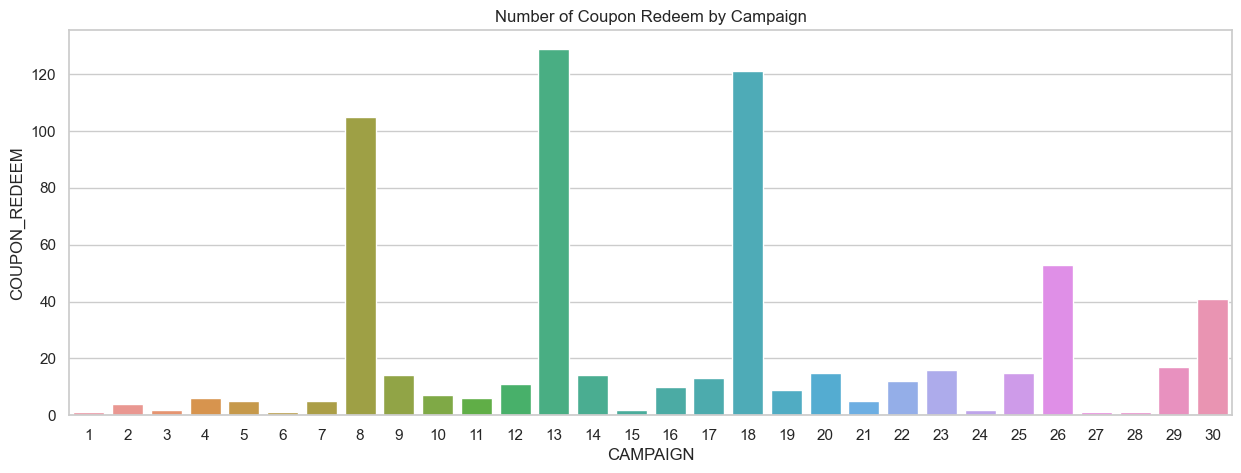

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(x='CAMPAIGN',y='COUPON_REDEEM',data=coupon_redeem)
plt.title("Number of Coupon Redeem by Campaign")
plt.show()

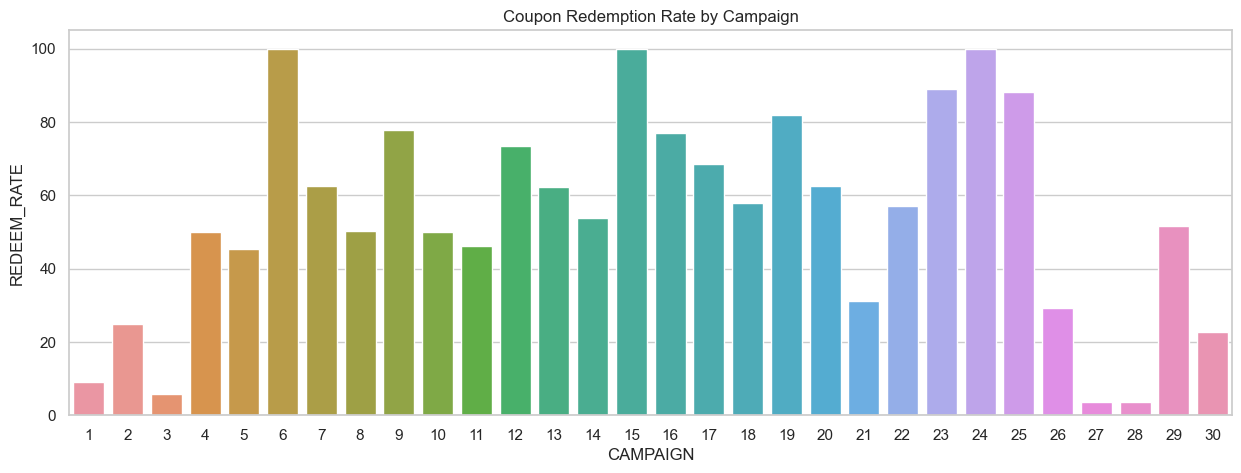

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(x='CAMPAIGN',y='REDEEM_RATE',data=coupon_redeem)
plt.title("Coupon Redemption Rate by Campaign")
plt.show()

#### Transaction Basket Analysis :-

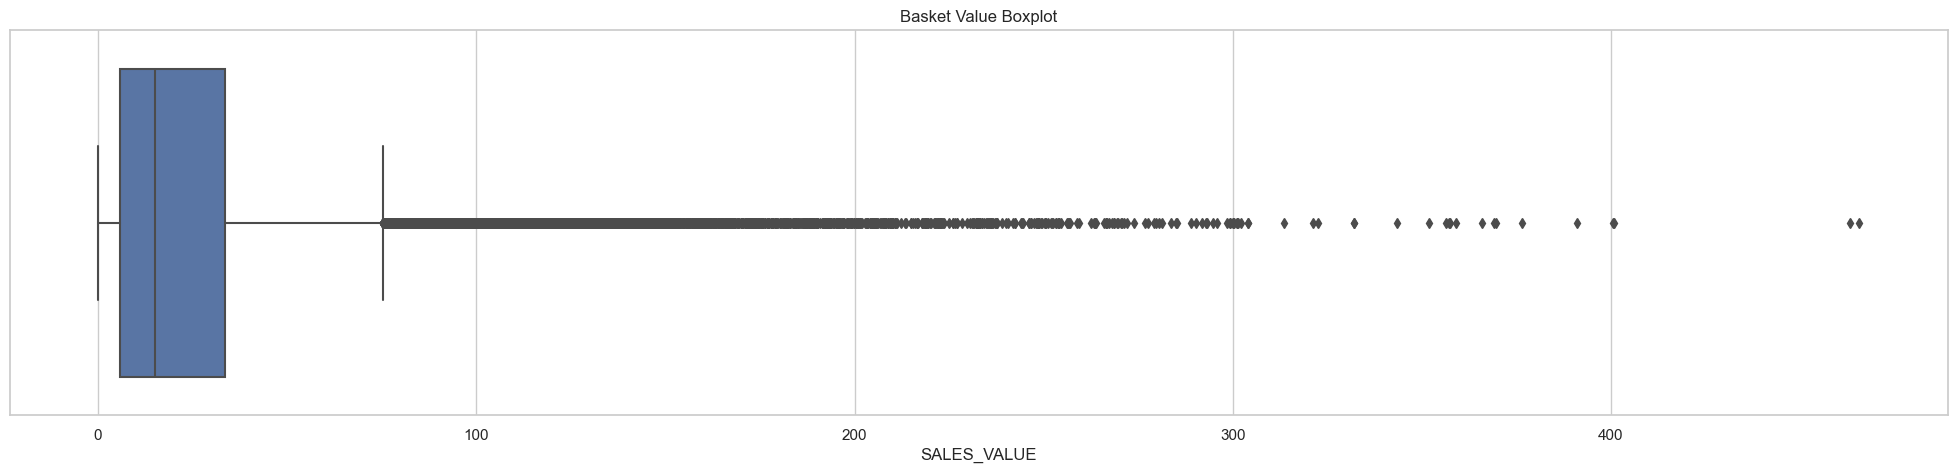

In [23]:
tranx_bucket = data['TRANSACTIONS_RAW'].groupby('BASKET_ID').aggregate({
    'SALES_VALUE':'sum',
    'COUPON_DISC':'sum',
    'COUPON_MATCH_DISC':'sum'
})
tranx_bucket['use_coupon'] = tranx_bucket['COUPON_DISC'] != 0

plt.figure(figsize=(25,5))
sns.boxplot(x=tranx_bucket['SALES_VALUE'])
plt.title("Basket Value Boxplot")
plt.show()


In [24]:
# Basket analysis based on coupon usage

basket_analysis = tranx_bucket.groupby('use_coupon').aggregate(
    Avg_sales = ('SALES_VALUE','mean'),
    coupon_disc = ('COUPON_DISC','mean'),
    coupon_match_disc = ('COUPON_MATCH_DISC','mean'),
    no_coupon = ('SALES_VALUE','count')
)
print(basket_analysis)

            Avg_sales  coupon_disc  coupon_match_disc  no_coupon
use_coupon                                                      
False       25.009980     0.000000           0.000000      47892
True        62.533348    -2.587167          -0.334364       2587


In [25]:
# Product-level analysis with transactions and coupon usage

tranx_desc = data['TRANSACTIONS_RAW'].merge(tranx_bucket,how='left',on='BASKET_ID')
tranx_desc = tranx_desc.merge(data['PRODUCT_RAW'],how='left',on='PRODUCT_ID')

commodity_coupon = tranx_desc.groupby('COMMODITY_DESC').aggregate(
    total_quantity = ('QUANTITY','sum'),
    use_coupon = ('use_coupon','sum'),
    coupon = ('COUPON_DISC_x','sum')
)
commodity_coupon['coupon%'] = round((commodity_coupon['use_coupon']/commodity_coupon['total_quantity'])*100,2)

In [26]:
print(commodity_coupon.sort_values('coupon%',ascending=False).head(20))

                         total_quantity  use_coupon  coupon  coupon%
COMMODITY_DESC                                                      
                                      0         872   -1396      inf
NATURAL VITAMINS                      2           1      -5    50.00
VALENTINE                             6           2       0    33.33
DIAPERS & DISPOSABLES               922         231    -215    25.05
RW FRESH PROCESSED MEAT               8           2       0    25.00
BABY HBC                            887         181     -82    20.41
BABY FOODS                         5787        1114     -38    19.25
LAUNDRY ADDITIVES                   948         176     -25    18.57
CAT LITTER                          587         104     -11    17.72
FRZN BREAKFAST FOODS               2073         347     -61    16.74
AIR CARE                           1154         193    -124    16.72
HOUSEHOLD CLEANG NEEDS             2166         355     -96    16.39
HAIR CARE PRODUCTS                

#### Sales trends by year :-

In [27]:
sales_trend = data['TRANSACTIONS_RAW'].groupby(data['TRANSACTIONS_RAW']['DATE'].dt.year).aggregate(
    {'SALES_VALUE':'sum',
     'RETAIL_DISC':'sum',
     'COUPON_DISC':'sum'
    })
print(sales_trend)

      SALES_VALUE  RETAIL_DISC  COUPON_DISC
DATE                                       
2020   1359551.73   -248978.11        -6693


#### Preparing Data for database loading :-

In [28]:
data['CAMPAIGN_DESC_RAW'] = data['CAMPAIGN_DESC_RAW'].merge((coupon_redeem.loc[:,['CAMPAIGN','COUPON_GIVEN','COUPON_REDEEM','REDEEM_RATE']]),how='left',on='CAMPAIGN').sort_values('CAMPAIGN')

In [29]:
# Transforming date columns for database loading

data['CAMPAIGN_DESC_RAW']['START_DATE'] = pd.to_datetime(data['CAMPAIGN_DESC_RAW']['START_DATE']).apply(lambda x: x.date())
data['CAMPAIGN_DESC_RAW']['END_DATE'] = pd.to_datetime(data['CAMPAIGN_DESC_RAW']['END_DATE']).apply(lambda x: x.date())

data['COUPON_REDEMPT_RAW']['DATE'] = pd.to_datetime(data['COUPON_REDEMPT_RAW']['DATE']).apply(lambda x: x.date())

data['TRANSACTIONS_RAW']['DATE'] = pd.to_datetime(data['TRANSACTIONS_RAW']['DATE']).apply(lambda x:x.date())

In [30]:
# Dropping unnecessary columns

data['CAMPAIGN_DESC_RAW'].drop(['START_DAY', 'END_DAY'], axis=1, inplace=True)

data['COUPON_REDEMPT_RAW'].drop('DAY', axis=1, inplace=True)

data['TRANSACTIONS_RAW'].drop(['WEEK_NO','DAY'],inplace=True, axis=1)

In [31]:
# Function for Creating tables in snowflake according to our data set

def snowflake_table_create(table_name, *table_schema):
    try:
        cur = conn.cursor()
        # Convert the schema tuple to a string with proper formatting
        schema_string = ', '.join(table_schema)
        # Execute the SQL command with the schema
        cur.execute(f'''CREATE OR REPLACE TABLE {table_name} ({schema_string})''')
        print(f"Table {table_name} created successfully.")
    except Exception as e:
        # Capture and print any exceptions that occur
        print(f"Error creating table {table_name}: {e}")
    finally:
        # Ensure the cursor is closed even if there is an error
        cur.close()


In [32]:
data['CAMPAIGN_DESC_RAW'].head(1)

,DESCRIPTION,CAMPAIGN,START_DATE,END_DATE,DURATION,COUPON_GIVEN,COUPON_REDEEM,REDEEM_RATE
23,TypeB,1,2020-12-12,2021-01-18,37,11,1,9.09


In [33]:
snowflake_table_create('CAMPAIGN_DESC_NEW', 'DESCRIPTION VARCHAR(7)', 'CAMPAIGN INT', 'START_DATE DATE', 'END_DATE DATE', 'DURATION INT', 'COUPON_GIVEN INT', 'COUPON_REDEEM INT', 'REDEEM_RATE FLOAT')

Table CAMPAIGN_DESC_NEW created successfully.


In [34]:
data['COUPON_REDEMPT_RAW'].head(1)

,HOUSEHOLD_KEY,COUPON_UPC,CAMPAIGN,DATE
0,1,10000085364,8,2021-02-25


In [35]:
snowflake_table_create('COUPON_REDEMPT_NEW', 'HOUSEHOLD_KEY INT', 'COUPON_UPC INT', 'CAMPAIGN INT', 'DATE DATE')

Table COUPON_REDEMPT_NEW created successfully.


In [36]:
data['TRANSACTIONS_RAW'].head(1)

,HOUSEHOLD_KEY,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC,DATE
0,2375,26984851472,1004906,1,1.39,364,-0.6,1631,0,0,2020-01-02


In [37]:
snowflake_table_create('TRANSACTIONS_NEW', 'HOUSEHOLD_KEY INT', 'BASKET_ID INT', 'PRODUCT_ID INT',
'QUANTITY INT', 'SALES_VALUE FLOAT', 'STORE_ID INT', 'RETAIL_DISC FLOAT', 'TRANS_TIME INT', 'COUPON_DISC INT',
'COUPON_MATCH_DISC INT', 'DATE DATE')

Table TRANSACTIONS_NEW created successfully.


In [38]:
# Function to load data back to Snowflake

def load_to_snowflake(df,table_name):
    try:
        success,nchunks,nrows,_ = write_pandas(conn,df,table_name,'RETAIL_PROJECT','PUBLIC')
        print(f"Table {table_name} loaded successfully : {success} , Rows:{nrows}")
    except Exception as e:
        print(f"Error while loading table {table_name} : {e} ")
        

In [39]:
# Loading data into respective sheets

load_to_snowflake(data['CAMPAIGN_DESC_RAW'],'CAMPAIGN_DESC_NEW')

load_to_snowflake(data['COUPON_REDEMPT_RAW'],'COUPON_REDEMPT_NEW')

load_to_snowflake(data['TRANSACTIONS_RAW'], 'TRANSACTIONS_NEW')

C:\Users\mishr\AppData\Local\Temp\ipykernel_12480\2567959249.py:5: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.base.Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success,nchunks,nrows,_ = write_pandas(conn,df,table_name,'RETAIL_PROJECT','PUBLIC')


Table CAMPAIGN_DESC_NEW loaded successfully : True , Rows:30
Table COUPON_REDEMPT_NEW loaded successfully : True , Rows:2318
Table TRANSACTIONS_NEW loaded successfully : True , Rows:450416


In [40]:
conn.close()